In [11]:
import os
import sys 
import glob
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
from scipy.interpolate import LinearNDInterpolator
# # importing from one directory  up
# sys.path.insert(0, "../" )
from misc import round_to_hour, angular_difference, calculate_distance, era5_wind_single_time_loc

from velocity_leakage import S1DopplerLeakage

## - Load DCA files

In [12]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/DCA/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios

['Aghulas_20190510',
 'Aghulas_20200121',
 'Aghulas_20191110',
 'Aghulas_20190515']

In [13]:
scenario = 'Aghulas_20190515'
files_dca = glob.glob(f"{data_dir+scenario}/*.nc")
files_dca = [file for file in files_dca if 'S1B' in file]
files_dca

['/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20190515/20190515T172402-WOC-L2P-CUReul-S1B-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20190515/20190515T172427-WOC-L2P-CUReul-S1B-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20190515/20190515T172337-WOC-L2P-CUReul-S1B-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20190515/20190515T172452-WOC-L2P-CUReul-S1B-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20190515/20190515T172312-WOC-L2P-CUReul-S1B-OSC_RVL-v1.0-fv1.1.nc']

## - Load Sentinel-1 files

In [14]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Morroco_20201103',
 'Aghulas_20200121',
 'Aghulas_20191110',
 'Iceland_20231107',
 'Scotland_20231109',
 'Aghulas_20190515']

In [21]:
scenario = 'Aghulas_20190515'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

observation = S1DopplerLeakage(
    filename=files,
    era5_directory= 'era5_winds/',
    scene_size=25_000,
    az_mask_cutoff=80_000,
    vx_sat=8000,
    PRF=4,
    resolution_spatial=200,
    length_antenna=3.2,
    beam_pattern='phased_array',
    )

In [22]:
# observation.open_data()
# observation.querry_era5()

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20190515/380C_A15C_E78E_EF27_FA2B_res200.nc


In [24]:
observation.apply()
observation.compute_leakage_velocity_estimate(speckle_noise=True)

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20190515/380C_A15C_E78E_EF27_FA2B_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_20190515h1700_lat-37_38_lon20_92.nc


In [25]:
obj_copy = copy.deepcopy(observation)

## - Interpolate and add DCA to Sentinel-1

In [26]:
ts = []
longitudes = []
latitudes = []
dcas = []
for i, file in enumerate(files_dca):
    data = xr.open_dataset(file)
    longitudes.append(data.lon.values.ravel())
    latitudes.append(data.lat.values.ravel())
    dcas.append(data.doppler_centroid_anomaly.values.ravel())

In [27]:
np.concatenate(dcas, axis = 0)
df = pd.DataFrame(
    data = {'lon': np.concatenate(longitudes, axis = 0),
            'lat': np.concatenate(latitudes, axis = 0),
            'dca': np.concatenate(dcas, axis = 0)})
df.where(abs(df) < 1e10, np.nan, inplace=True)
df.dropna(inplace=True)

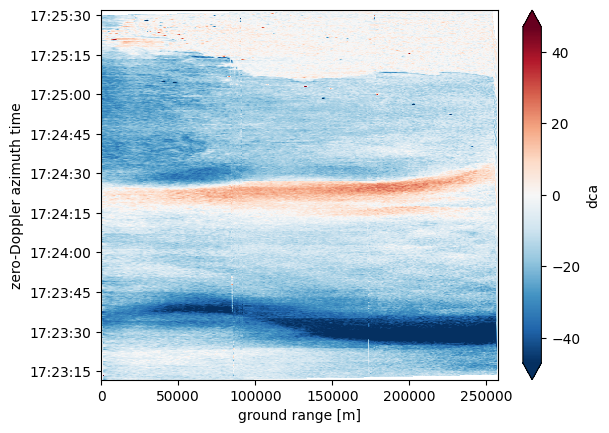

In [28]:
interp = LinearNDInterpolator(list(zip(df.lon.values, df.lat.values)), df.dca.values)

dca_interp = interp(obj_copy.S1_file.longitude.values, obj_copy.S1_file.latitude.values)
obj_copy.S1_file['dca'] = (['azimuth_time', 'ground_range'], dca_interp)

obj_copy.S1_file.dca.plot(robust = True)

In [29]:
obj_copy.create_dataset()

In [30]:
obj_copy.data['dca'] = (['az', 'grg'], obj_copy.S1_file['dca'].data)
obj_copy.create_beam_mask()

In [41]:
# compute weighted received Doppler and resulting apparent LOS velocity
observation.data['dop_w_dca_beam_weighted'] = (obj_copy.data.dca + observation.data['dop_geom']) * observation.data['beam']* observation.data['nrcs_weight']
observation.data['dca_beam_weighted'] = obj_copy.data.dca * observation.data['beam'] * observation.data['nrcs_weight']

# sum over azimuth to receive range-slow_time results
weight_rg = (observation.data['beam'] * observation.data['nrcs_weight']).sum(dim='az_idx', skipna=False)
receive_rg = observation.data['dop_w_dca_beam_weighted'].sum(dim='az_idx', skipna=False)
observation.data[['dca_pulse_rg']] = observation.data['dca_beam_weighted'].sum(dim='az_idx', skipna=False) / weight_rg
observation.data[['doppler_w_dca_pulse_rg']] = receive_rg / weight_rg

observation.data['doppler_w_dca_pulse_rg_subscene'] = observation.data['doppler_w_dca_pulse_rg'].rolling(grg=observation.grg_N, slow_time=observation.slow_time_N, center=True).mean()
observation.data['dca_pulse_rg_subscene'] = observation.data['dca_pulse_rg'].rolling(grg=observation.grg_N, slow_time=observation.slow_time_N, center=True).mean()

observation.data = observation.data.transpose('az_idx', 'grg', 'slow_time')

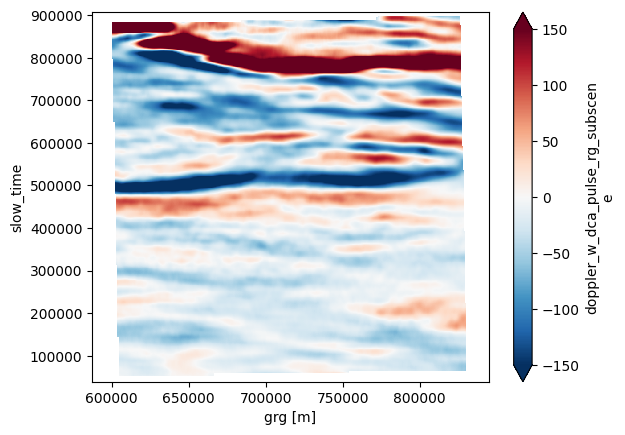

In [49]:
(observation.data['doppler_w_dca_pulse_rg_subscene']).T.plot(vmax = 150)

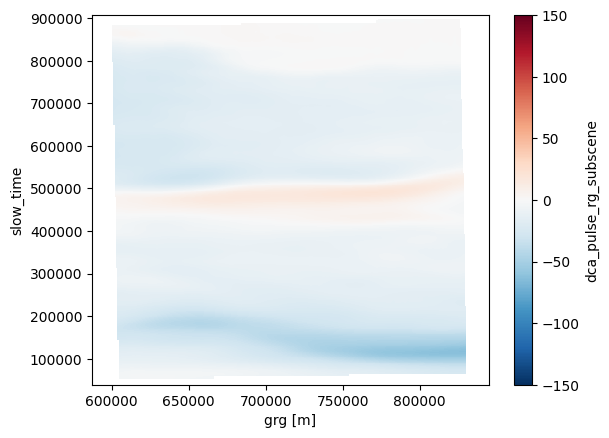

In [50]:
(observation.data['dca_pulse_rg_subscene']).T.plot(vmax = 150)

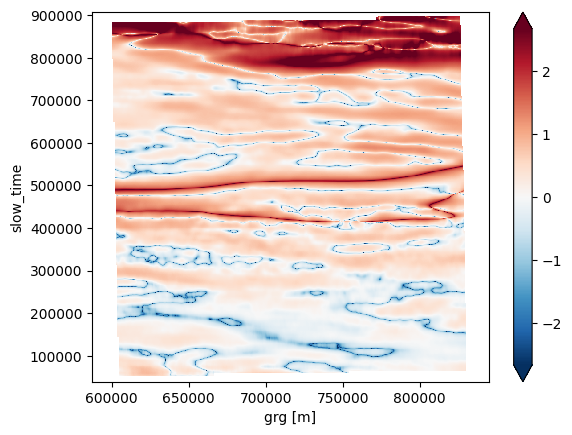

In [46]:
np.log10(abs(observation.data['doppler_w_dca_pulse_rg_subscene']/observation.data['dca_pulse_rg_subscene'])).T.plot(robust = True)

In [51]:
observation.data

<xarray.Dataset>
Dimensions:                               (az_idx: 401, grg: 1288,
                                           slow_time: 434)
Coordinates:
  * grg                                   (grg) float64 5.874e+05 ... 8.448e+05
  * az_idx                                (az_idx) int64 0 200 ... 79800 80000
  * slow_time                             (slow_time) float64 4e+04 ... 9.06e+05
Data variables: (12/36)
    nrcs                                  (az_idx, grg, slow_time) float32 dask.array<chunksize=(401, 1288, 1), meta=np.ndarray>
    inc                                   (az_idx, grg, slow_time) float32 dask.array<chunksize=(401, 1288, 1), meta=np.ndarray>
    windfield                             (az_idx, grg, slow_time) float32 dask.array<chunksize=(401, 1288, 1), meta=np.ndarray>
    x_sat                                 (slow_time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    az                                    (az_idx, slow_time) float32 dask.array<chunksize=(401, 1), meta=np.ndarray>
    distance_az                           (az_idx) float32 dask.array<chunksize=(401,), meta=np.ndarray>
    ...                                    ...
    dop_w_dca_beam_weighted               (az_idx, grg, slow_time) float32 dask.array<chunksize=(401, 1288, 1), meta=np.ndarray>
    doppler_w_dca_pulse_rg                (grg, slow_time) float32 dask.array<chunksize=(1288, 1), meta=np.ndarray>
    doppler_w_dca_pulse_rg_subscene       (grg, slow_time) float32 dask.array<chunksize=(1287, 12), meta=np.ndarray>
    dca_beam_weighted                     (az_idx, grg, slow_time) float32 dask.array<chunksize=(401, 1288, 1), meta=np.ndarray>
    dca_pulse_rg                          (grg, slow_time) float32 dask.array<chunksize=(1288, 1), meta=np.ndarray>
    dca_pulse_rg_subscene                 (grg, slow_time) float32 dask.array<chunksize=(1287, 12), meta=np.ndarray>
Attributes: (12/23)
    wdir_wrt_sensor:                 133.72618478608467
    resolution_spatial:              200
    filename:                        ['/Users/opodriscoll/Documents/Data/Sent...
    f0:                              5300000000.0
    z0:                              700000.0
    length_antenna:                  3.2
    ...                              ...
    _denoise:                        True
    Lambda:                          0.05660377358490566
    stride:                          2000.0
    az_mask_pixels_cutoff:           200
    grg_N:                           125
    slow_time_N:                     12